## 3.2 Второй этап обучения

На втором этапе обучения предскажем вероятность оттока клиентов по предсказанному времени до последней транзакции.

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import catboost as cat

from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    roc_auc_score,
    accuracy_score,
    f1_score,
    recall_score, 
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve, 
    auc
)

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM = 42

In [2]:
features = pd.read_csv('/Users/Elena/Desktop/Задание/Фичи/features_4.csv', index_col = 0)
train = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/train.csv')
clients = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/clients.csv')
test = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/sample_submit_naive.csv')
time_predict = pd.read_csv('/Users/Elena/Desktop/Задание/test_time_predict.csv', index_col = 0)

In [3]:
# Объединяем таблицу features с таблицей train по столбцу 'user_id', используя внутреннее соединение
train_features = features.merge(train, on = 'user_id', how = 'inner')

# Объединяем полученную таблицу train_features с таблицей clients по столбцу 'user_id', используя левое соединение
train_features = train_features.merge(clients, on = 'user_id', how = 'left')

In [4]:
# Заполняем пропуски в столбце 'employee_count_nm' значением 'empty'
train_features['employee_count_nm'] = train_features['employee_count_nm'].fillna('empty')

In [5]:
# Преобразуем столбцы 'report', 'employee_count_nm', 'employee_category' и 'bankemplstatus' 
# в категориальный тип данных
train_features['report'] = train_features['report'].astype('category')
train_features['employee_count_nm'] = train_features['employee_count_nm'].astype('category')
train_features['bankemplstatus'] = train_features['bankemplstatus'].astype('category')

In [6]:
# Удаляем дубликаты из DataFrame train_features, оставляя только последние вхождения
train_features = train_features.drop_duplicates(keep='last')

In [7]:
# Создаем список столбцов для обучения, исключая 'user_id', 'target' и 'mcc_code'
train_cols = [x for x in train_features.columns if x not in ['user_id', 'target', 'mcc_code']]

# Определяем категориальные столбцы, которые будут использоваться в модели
cat_cols = ['report', 'employee_count_nm', 'bankemplstatus']

# Задаем переменную target, указывая на столбец с целевой переменной
target = 'target'

In [8]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    train_features[train_cols],  # Выбираем признаки для обучения
    train_features[target],       # Выбираем целевую переменную
    test_size=0.25,              # Указываем размер тестовой выборки (25% от общего объема)
    random_state=RANDOM,         # Устанавливаем случайное состояние для воспроизводимости результатов
    stratify=train_features[target]  # Сохраняем пропорции целевой переменной в обеих выборках
)

In [9]:
# Инициализация модели CatBoostClassifier
model = CatBoostClassifier(
    random_state=RANDOM,        # Устанавливаем случайное состояние для воспроизводимости результатов
    depth=10,                   # Задаем максимальную глубину деревьев (10)
    eval_metric="AUC",          # Указываем метрику для оценки качества модели (площадь под кривой ROC)
    cat_features=cat_cols,      # Указываем список категориальных признаков
    l2_leaf_reg=5               # Устанавливаем коэффициент L2 регуляризации для уменьшения переобучения
)

In [10]:
# Обучение модели на тренировочных данных
model.fit(
    X_train,                   # Тренировочные признаки
    y_train,                   # Тренировочные целевые значения
    eval_set=(X_test, y_test), # Набор для оценки модели (тестовые данные)
    early_stopping_rounds=100, # Остановка обучения, если в течение 100 итераций не наблюдается улучшения
    cat_features=cat_cols,     # Указываем категориальные признаки
    verbose=False              # Отключаем вывод информации о процессе обучения
)

In [11]:
# Получаем вероятности положительного класса для тестовых данных
test_predict = model.predict_proba(X_test)[:, 1]

# Вычисляем AUC (площадь под кривой ROC) для предсказанных вероятностей
auc_test = roc_auc_score(y_test, test_predict)

# Вычисление значений для кривой ROC
fpr, tpr, thresholds = roc_curve(y_test, test_predict)
roc_auc = auc(fpr, tpr)

In [12]:
auc_test

0.9050300029993923

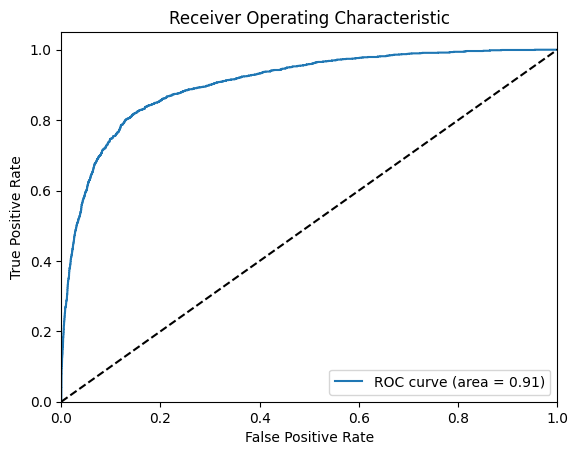

In [13]:
# Построение графика кривой ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Построение матрицы ошибок и ее анализ**

In [14]:
# Предположим, что test_predict содержит вероятности
# Преобразуем вероятности в бинарные метки
threshold = 0.5
binary_predictions = (test_predict >= threshold).astype(int)

# Вычисление precision
precision = precision_score(y_test, binary_predictions, pos_label=1)

# Вычисление recall
recall = recall_score(y_test, binary_predictions, pos_label=1)

# Вычисление F1-меры
f1 = f1_score(y_test, binary_predictions, pos_label=1)

# Вывод результатов
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.6796657381615598
Recall: 0.3604135893648449
F1-score: 0.4710424710424711


In [15]:
# Объединяем датафрейм features с 'test' по 'user_id', оставляя только совпадающие записи,
# чтобы оставить только тех user_id, которые нужны для предсказания
test_features = features.merge(test[['user_id']], on='user_id', how='inner')

# Объединяем полученные тестовые признаки с данными о клиентах, добавляя информацию о клиентах
test_features = test_features.merge(clients, on='user_id', how='left')

# Объединяем полученные тестовые признаки с предсказанным временем, добавляя соответствующую информацию
test_features = test_features.merge(time_predict, on='user_id', how='left')

In [16]:
# Заполняем пропуски в столбце 'employee_count_nm' значением 'empty'
test_features['employee_count_nm'] = test_features['employee_count_nm'].fillna('empty')

# Преобразуем указанные категориальные столбцы в тип 'category'
test_features[cat_cols] = test_features[cat_cols].astype('category')

In [17]:
# Создаем новый DataFrame 'submit', содержащий только столбец 'user_id' из 'test_features'
submit = test_features[['user_id']]

# Предсказываем вероятности для положительного класса с использованием обученной модели
# 'predict_proba' возвращает вероятности для обоих классов, поэтому выбираем второй столбец ([:, 1])
submit['predict'] = model.predict_proba(test_features[train_cols])[:, 1]

In [18]:
# Сохраняем DataFrame 'submit' в CSV файл 'submit_2.csv', без индексов
submit.to_csv('submit_2.csv', index=0)